# Cleaning Modes With Rational Filters

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
from scipy.special import logsumexp

In [20]:
theoretical_values = (68.6, 0.71)

## Data

Download data

In [21]:
home_dir = "./MDC_waveforms/"

In [22]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [23]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

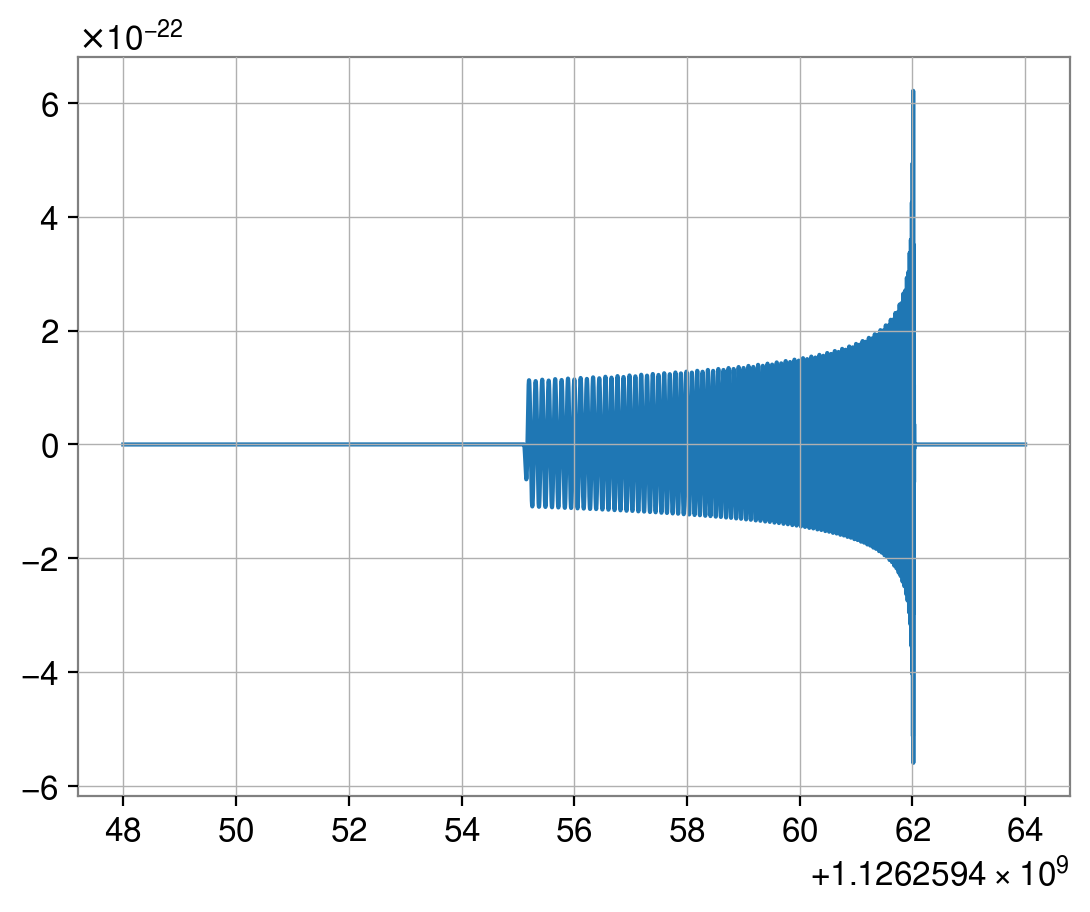

In [24]:
pl.plot(H_data)
# pl.plot(L_data)

In [25]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [26]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

In [27]:
SSB_peak_time

1126259461.9987423

In [28]:
asd = np.loadtxt('./LIGO-asd.txt')

In [29]:
asd_freqs = asd[:,0]
asd_amps = asd[:,1]
asd_interp = interp1d(asd_freqs, asd_amps)
# freq_space = np.logspace(np.log10(asd_freqs[0]), np.log10(asd_freqs[-1]), 4096)
freq_space = np.linspace(asd_freqs[0], asd_freqs[0]+2048, 2048*2)

In [30]:
# np.savetxt('resampled_asd.txt', np.c_[(freq_space, asd_interp(freq_space))])

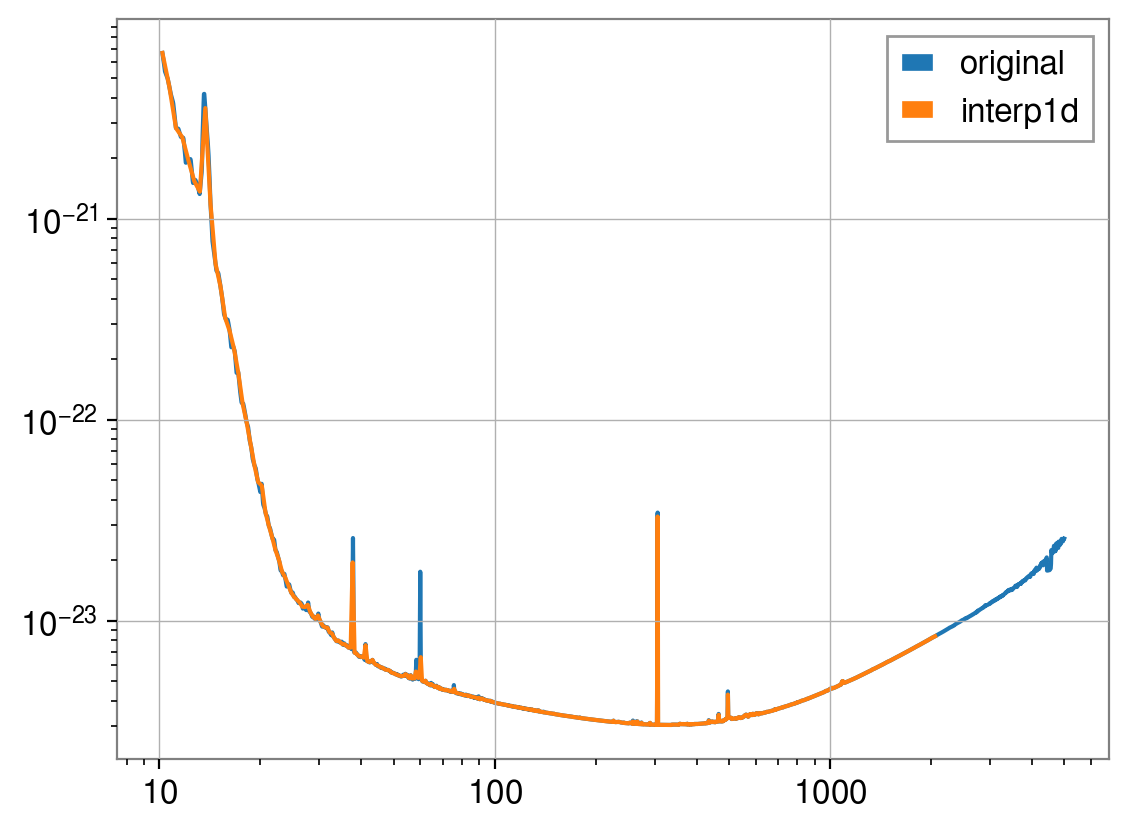

In [31]:
pl.loglog(asd_freqs, asd_amps, label = 'original')
pl.loglog(freq_space, asd_interp(freq_space), label = 'interp1d')
# pl.loglog(freq_space, y2, label = 'spline')
pl.legend()

## Filter

In [32]:
mass_unit = qnm_filter.Filter.mass_unit(theoretical_values[0])

In [33]:
input = dict(model_list = [(2,2,0),(2,1,0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+0*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [34]:
fit.original_data['H1'] = H_waveform

In [35]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [36]:
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.Noise('asd')
fit.pure_noise['H1'].load_noise_curve('asd', './resampled_asd.txt')
fit.pure_noise['H1'].from_asd()

In [37]:
fit.acfs['H1'] = qnm_filter.Data(fit.pure_noise['H1'].acf)#.iloc[:8190//2+1])

In [38]:
fit.cholesky_decomposition()

In [39]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [40]:
fit.compute_SNR(0, template, 'H1', optimal=True)

13.528447209553503

In [41]:
10*(1/4096/mass_unit)

7.225475139227191

In [42]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [43]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [45]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [46]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

In [47]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(105, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

SyntaxError: invalid syntax (1442815359.py, line 23)

## Automated with multiple filters

In [49]:
model_arr = [[(2,2,0)], [(2,2,0), (2,2,1)], [(2,2,0),(2,2,1),(2,2,2)]]
evidence_arr = []

In [99]:
[(2,2,0)].append(tuple((7,7,0)))

In [116]:
# Generate the list using list comprehension
result_list = [(7,7,0) for _ in range(30)]
result_list.insert(0, (2, 2, 0))


In [104]:
evidence_arr = []
for i in range(10):
    input['model_list'] = [tuple((7,7,0)) for i in range(i)]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.compute_acfs('original_data')
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Noise('asd')
    fit.pure_noise['H1'].load_noise_curve('asd', './resampled_asd.txt')
    fit.pure_noise['H1'].from_asd()
    fit.acfs['H1'] = qnm_filter.Data(fit.pure_noise['H1'].acf)
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

[]
[(7, 7, 0)]
[(7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


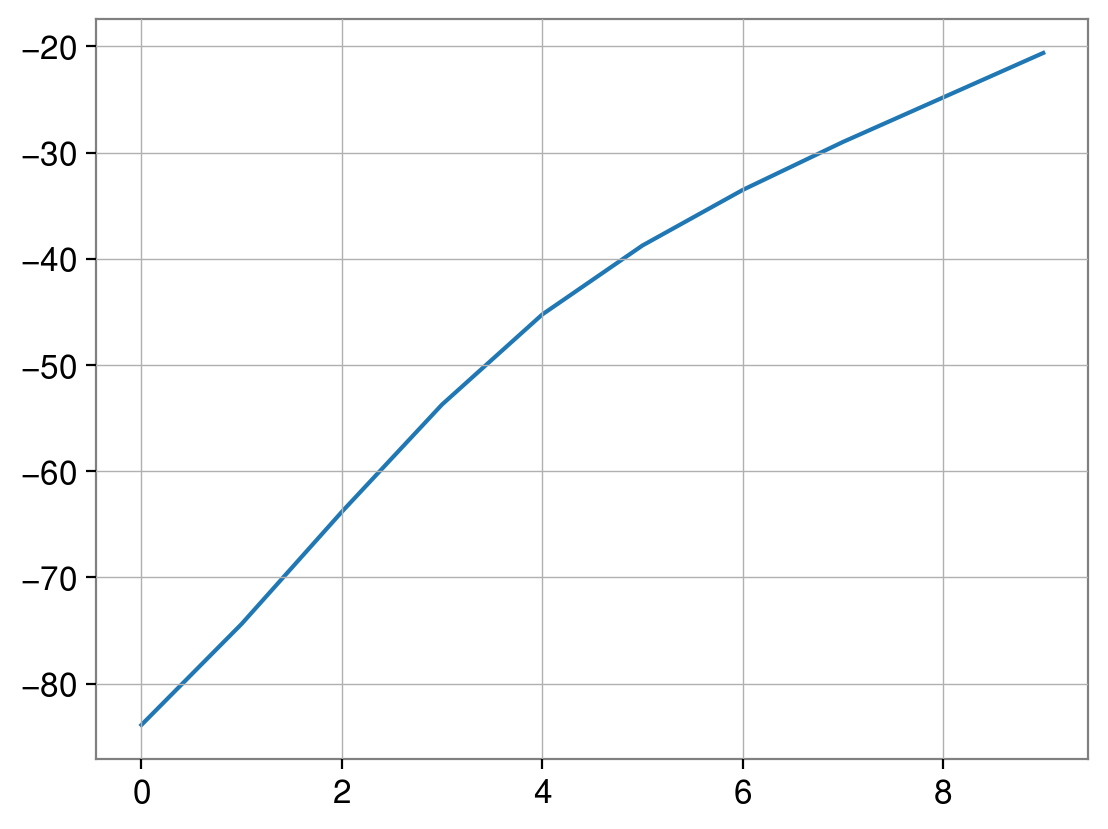

In [105]:
pl.plot(evidence_arr)